<a href="https://colab.research.google.com/github/rajy4683/S15FinalSubmission/blob/master/LossFunctionsResults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys

Mounted at /content/drive


In [0]:
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')
sys.path.append('/content/drive/My Drive/EVA4')
sys.path.append('/content/drive/My Drive/EVA4/DenseDepth')

In [0]:
!folder_list=("classroom" "college_outdoors" "corridors" "dining_room" "malls" "lobby" "meeting_rooms" "people_cropresize"); for folder_name in ${folder_list[@]}; do mkdir -p /content/S15EVA4/$folder_name /content/S15EVA4/$folder_name/aug_images; cp -Rf /content/drive/My\ Drive/EVA4/tsai/S15EVA4/$folder_name/*png /content/S15EVA4/$folder_name; done

### Dependencies


In [0]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

In [0]:
!pip install -U git+https://github.com/albu/albumentations

In [0]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import pandas as pd

import torch
from zipfile import ZipFile
import re
import h5py
import time



In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from RekogNizer import hyperparams

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg, IAAFliplr,
	IAAPerspective,
)
from albumentations.pytorch import ToTensor
import random

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import os
import sys
import numpy as np
from torchvision import datasets
#from RekogNizer import imgnetloader
from RekogNizer import basemodelclass
from RekogNizer import mmdtraintest
from RekogNizer import mmddataloader
from RekogNizer import hyperparams
from RekogNizer import fileutils
from RekogNizer import mmdlosses
from RekogNizer import mmdmodels


from torch.utils.data import Dataset
import shutil
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, CyclicLR, ReduceLROnPlateau


import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import wandb

  pip install torch-lr-finder -v --global-option="amp"
  pip install torch-lr-finder -v --global-option="amp"


In [0]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
#tqdm._instances.clear()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
!rm -rf /content/train && mkdir -p /content/train
!rm -rf /content/test && mkdir -p /content/test

In [0]:
pd.read_csv('/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv').shape

(338674, 7)

In [0]:
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
batch_start = 0
batch_end = batch_start+338674
train_batch_size = 64
dest_dir="/content/train"

mmddataloader.extract_data_files(csv_file, root_dir, batch_start,batch_end, dest_dir=dest_dir)

Extracting image and mask files


image_mask_gt8k12k.zip: 100%|██████████| 229500/229500 [05:40<00:00, 674.86it/s] 


Extracting depth files


depth_mask_gt_8k12k.zip: 100%|██████████| 114750/114750 [03:57<00:00, 483.03it/s] 


Extracting bg files
Total file count:1016132 


In [0]:
%%time
size_hw = (64,64)
dest_dir="/content/train"
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, dest_dir, batch_start,batch_end, read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)


CPU times: user 1.01 s, sys: 76.3 ms, total: 1.09 s
Wall time: 1.77 s


In [0]:
pd.read_csv('/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv').shape

(145146, 7)

In [0]:
test_csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
test_batch_start = 0
test_batch_end = test_batch_start + 145146
test_batch_size=16
test_dest_dir = "/content/test"

mmddataloader.extract_data_files(test_csv_file, root_dir, test_batch_start,test_batch_end, dest_dir=test_dest_dir)

Extracting image and mask files


image_mask_gt8k12k.zip: 100%|██████████| 98500/98500 [04:30<00:00, 363.97it/s] 


Extracting depth files


depth_mask_gt_8k12k.zip: 100%|██████████| 49250/49250 [01:44<00:00, 472.55it/s]


Extracting bg files
Total file count:435548 


In [0]:
size_hw = (64,64)
test_dest_dir = "/content/test"
test_dataset = mmddataloader.DepthMaskDataSet(test_csv_file, test_dest_dir, test_batch_start,test_batch_end,read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, **kwargs)

In [0]:
#csv_file = '/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSetSample.csv'
batch_start = 70000
batch_end = batch_start+30000
train_batch_size = 64

test_batch_start = 0
test_batch_end = test_batch_start + 512
test_batch_size=16

csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
test_csv_file = '/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv'

root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
size_hw = (64,64)
#size_hw = (224,224)
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, root_dir, batch_start,batch_end, read_zip=True,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)

test_dataset = mmddataloader.DepthMaskDataSet(test_csv_file, root_dir, test_batch_start,test_batch_end,read_zip=True,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, **kwargs)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
0.2558585886905646 1.733803997754138 0.8400992751121521
{'lr': [0.10069316688518043, 0.10139113857366795, 0.102093948370768, 0.10280162981264736, 0.1035142166679344, 0.10423174293933042, 0.10495424286523224, 0.10568175092136585, 0.10641430182243161, 0.10715193052376065, 0.10789467222298288, 0.10864256236170655, 0.1093956366272094, 0.1101539309541415, 0.1109174815262401, 0.11168632477805612, 0.11246049739669264, 0.11324003632355571, 0.11402497875611686, 0.1148153621496883, 0.11561122421920988, 0.11641260294104915, 0.11721953655481306, 0.11803206356517298, 0.11885022274370186, 0.11967405313072435, 0.12050359403717975, 0.12133888504649773, 0.12217996601648717, 0.12302687708123816, 0.12387965865303692, 0.1247383514242943, 0.1256029963694875, 0.12647363474711512, 0.12735030810166617, 0.12823305826560213, 0.12912192736135342, 0.13001695780332903, 0.1309181922999407, 0.1318256738556407

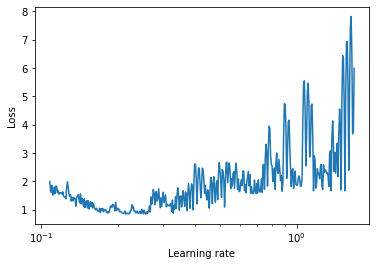

In [0]:
### LR finder ###
from RekogNizer import mmdtraintest
criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss], "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}
model_new = mmdmodels.UNet(n_channels=6, n_classes=2)
optimizer=optim.SGD(model_new.parameters(), lr=0.001,momentum=0.9,  weight_decay=0)
lrfinder = mmdtraintest.find_lr_type1(model_new, optimizer, criterion, train_loader, testloader=None, seed=1, start_lr=0.1, end_lr=100, step_mode="exp",num_iter=1000)
min_lr = lrfinder.history['lr'][np.argmin(lrfinder.history['loss'])]
max_lr = np.max(lrfinder.history['lr'])
print(min_lr, max_lr, np.min(lrfinder.history['loss']))
print(lrfinder.history)
lrfinder.plot()
lrfinder.reset()


In [0]:
np.min(lrfinder.history['loss'])

0.5309022665023804

In [0]:
del model_new
torch.cuda.empty_cache()

In [0]:
# #model.eval()
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)

model_new = mmdtraintest.load_model_for_infer(model_new, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-a396bcbcf1.h5',
                                  device)

In [0]:
summary(model.to(device),input_size=(6, 224, 224))

In [0]:
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 20
hyperparams.hyperparameter_defaults['lr'] = 2.5000e-02

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
                        weight_decay=0)

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss], 
           "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)

final_model_path = mmdtraintest.execute_model(model_new, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=False)


Initializing datasets and dataloaders


  0%|          | 0/469 [00:00<?, ?it/s]

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 20
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.025
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.5
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 2cb540e070
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  value: 1
split_pct:
  desc: null
  v

loss=0.225535 m_loss=0.148975 d_loss=0.076560 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
loss=0.1962527483701706 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]



Epoch: 1 Train set: Average loss: 0.2151, Mask loss:0.0818, Depth loss:0.1332, lr:0
Epoch: 1 Test set: Average loss: 0.0304, Mask loss:0.0190, Depth loss:0.0114
Model saved as Test loss reduced from  10000.0  to  0.030444904900433726


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.219302 m_loss=0.144967 d_loss=0.074335 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.2120, Mask loss:0.0809, Depth loss:0.1311, lr:0
Epoch: 2 Test set: Average loss: 0.0305, Mask loss:0.0190, Depth loss:0.0115
Non CyclicLR Case


loss=0.215262 m_loss=0.142287 d_loss=0.072975 batch_id=468: 100%|██████████| 469/469 [02:09<00:00,  3.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.2094, Mask loss:0.0800, Depth loss:0.1295, lr:0
Epoch: 3 Test set: Average loss: 0.0308, Mask loss:0.0191, Depth loss:0.0116
Non CyclicLR Case


loss=0.211700 m_loss=0.139924 d_loss=0.071776 batch_id=468: 100%|██████████| 469/469 [02:08<00:00,  3.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.2077, Mask loss:0.0792, Depth loss:0.1285, lr:0
Epoch: 4 Test set: Average loss: 0.0312, Mask loss:0.0193, Depth loss:0.0118
Non CyclicLR Case
Epoch     4: reducing learning rate of group 0 to 1.2500e-02.


loss=0.214553 m_loss=0.141393 d_loss=0.073160 batch_id=468: 100%|██████████| 469/469 [02:07<00:00,  3.69it/s]
loss=0.1940344274044037 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.51it/s]



Epoch: 5 Train set: Average loss: 0.2028, Mask loss:0.0748, Depth loss:0.1280, lr:0
Epoch: 5 Test set: Average loss: 0.0294, Mask loss:0.0186, Depth loss:0.0108
Model saved as Test loss reduced from  0.030444904900433726  to  0.029379425457811262


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.209915 m_loss=0.138055 d_loss=0.071860 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]
loss=0.1939401924610138 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.73it/s]



Epoch: 6 Train set: Average loss: 0.1990, Mask loss:0.0740, Depth loss:0.1250, lr:0
Epoch: 6 Test set: Average loss: 0.0294, Mask loss:0.0186, Depth loss:0.0108
Model saved as Test loss reduced from  0.029379425457811262  to  0.029365849309032657


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.206876 m_loss=0.135909 d_loss=0.070967 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.1965, Mask loss:0.0734, Depth loss:0.1231, lr:0
Epoch: 7 Test set: Average loss: 0.0294, Mask loss:0.0186, Depth loss:0.0108
Non CyclicLR Case


loss=0.204362 m_loss=0.134197 d_loss=0.070165 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.1944, Mask loss:0.0728, Depth loss:0.1217, lr:0
Epoch: 8 Test set: Average loss: 0.0294, Mask loss:0.0187, Depth loss:0.0108
Non CyclicLR Case


loss=0.201948 m_loss=0.132508 d_loss=0.069440 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.1927, Mask loss:0.0722, Depth loss:0.1204, lr:0
Epoch: 9 Test set: Average loss: 0.0295, Mask loss:0.0188, Depth loss:0.0108
Non CyclicLR Case
Epoch     9: reducing learning rate of group 0 to 6.2500e-03.


loss=0.201472 m_loss=0.131394 d_loss=0.070079 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]
loss=0.19530481100082397 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.29it/s]



Epoch: 10 Train set: Average loss: 0.1900, Mask loss:0.0704, Depth loss:0.1196, lr:0
Epoch: 10 Test set: Average loss: 0.0285, Mask loss:0.0181, Depth loss:0.0104
Model saved as Test loss reduced from  0.029365849309032657  to  0.02850716338868727


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.199239 m_loss=0.129737 d_loss=0.069502 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.72it/s]
loss=0.194698303937912 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.81it/s]



Epoch: 11 Train set: Average loss: 0.1883, Mask loss:0.0698, Depth loss:0.1185, lr:0
Epoch: 11 Test set: Average loss: 0.0285, Mask loss:0.0181, Depth loss:0.0104
Model saved as Test loss reduced from  0.02850716338868727  to  0.028474688878533435


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.197636 m_loss=0.128562 d_loss=0.069074 batch_id=468: 100%|██████████| 469/469 [02:07<00:00,  3.67it/s]
loss=0.19391366839408875 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.34it/s]



Epoch: 12 Train set: Average loss: 0.1871, Mask loss:0.0694, Depth loss:0.1176, lr:0
Epoch: 12 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0104
Model saved as Test loss reduced from  0.028474688878533435  to  0.028449710901485317


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.196245 m_loss=0.127569 d_loss=0.068676 batch_id=468: 100%|██████████| 469/469 [02:07<00:00,  3.69it/s]
loss=0.19321106374263763 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.49it/s]



Epoch: 13 Train set: Average loss: 0.1860, Mask loss:0.0691, Depth loss:0.1169, lr:0
Epoch: 13 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0104
Model saved as Test loss reduced from  0.028449710901485317  to  0.028433736914779708


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.194949 m_loss=0.126643 d_loss=0.068306 batch_id=468: 100%|██████████| 469/469 [02:07<00:00,  3.68it/s]
loss=0.19257232546806335 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.72it/s]



Epoch: 14 Train set: Average loss: 0.1850, Mask loss:0.0688, Depth loss:0.1162, lr:0
Epoch: 14 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0103
Model saved as Test loss reduced from  0.028433736914779708  to  0.028422638861059446


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.193744 m_loss=0.125799 d_loss=0.067944 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.70it/s]
loss=0.19201670587062836 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.63it/s]



Epoch: 15 Train set: Average loss: 0.1841, Mask loss:0.0685, Depth loss:0.1156, lr:0
Epoch: 15 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0103
Model saved as Test loss reduced from  0.028422638861059446  to  0.02841164081649706


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.192588 m_loss=0.124992 d_loss=0.067596 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]
loss=0.19182166457176208 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.81it/s]



Epoch: 16 Train set: Average loss: 0.1833, Mask loss:0.0682, Depth loss:0.1150, lr:0
Epoch: 16 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0103
Model saved as Test loss reduced from  0.02841164081649706  to  0.02840948514422478


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.191480 m_loss=0.124221 d_loss=0.067259 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]
loss=0.19123485684394836 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.04it/s]



Epoch: 17 Train set: Average loss: 0.1824, Mask loss:0.0679, Depth loss:0.1145, lr:0
Epoch: 17 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0103
Model saved as Test loss reduced from  0.02840948514422478  to  0.02840040060627995


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.190379 m_loss=0.123452 d_loss=0.066926 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.72it/s]
loss=0.19052550196647644 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]



Epoch: 18 Train set: Average loss: 0.1817, Mask loss:0.0677, Depth loss:0.1140, lr:0
Epoch: 18 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0103
Model saved as Test loss reduced from  0.02840040060627995  to  0.028393997783549348


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.189338 m_loss=0.122703 d_loss=0.066634 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]
loss=0.18979957699775696 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]



Epoch: 19 Train set: Average loss: 0.1809, Mask loss:0.0674, Depth loss:0.1135, lr:0
Epoch: 19 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0103
Model saved as Test loss reduced from  0.028393997783549348  to  0.028383599009662575


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.188326 m_loss=0.122006 d_loss=0.066320 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.70it/s]
loss=0.18928340077400208 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.69it/s]



Epoch: 20 Train set: Average loss: 0.1801, Mask loss:0.0672, Depth loss:0.1130, lr:0
Epoch: 20 Test set: Average loss: 0.0284, Mask loss:0.0181, Depth loss:0.0103
Model saved as Test loss reduced from  0.028383599009662575  to  0.0283760898701164
Non CyclicLR Case
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-2cb540e070.h5  best loss: 0.0283760898701164


### Baseline: 
/content/drive/My Drive/EVA4/model_saves/model-978efe44ad.h5 (UNet + criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss],            "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]})

In [0]:
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 40
hyperparams.hyperparameter_defaults['lr'] = 2.5000e-02

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
                        weight_decay=0)

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss], 
           "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)

final_model_path = mmdtraintest.execute_model(model_new, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=False)


Initializing datasets and dataloaders


  0%|          | 0/469 [00:00<?, ?it/s]

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 40
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.025
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.5
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 21a9faf062
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  value: 1
split_pct:
  desc: null
  v

loss=0.191688 m_loss=0.124573 d_loss=0.067115 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.72it/s]
loss=0.19236338138580322 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.27it/s]



Epoch: 1 Train set: Average loss: 0.1892, Mask loss:0.0735, Depth loss:0.1156, lr:0
Epoch: 1 Test set: Average loss: 0.0289, Mask loss:0.0183, Depth loss:0.0106
Model saved as Test loss reduced from  10000.0  to  0.028895928206731935


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.188256 m_loss=0.122179 d_loss=0.066077 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.1884, Mask loss:0.0733, Depth loss:0.1151, lr:0
Epoch: 2 Test set: Average loss: 0.0291, Mask loss:0.0184, Depth loss:0.0107
Non CyclicLR Case


loss=0.187158 m_loss=0.121209 d_loss=0.065949 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.1886, Mask loss:0.0731, Depth loss:0.1155, lr:0
Epoch: 3 Test set: Average loss: 0.0292, Mask loss:0.0184, Depth loss:0.0108
Non CyclicLR Case


loss=0.191901 m_loss=0.123858 d_loss=0.068042 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.1918, Mask loss:0.0736, Depth loss:0.1183, lr:0
Epoch: 4 Test set: Average loss: 0.0299, Mask loss:0.0185, Depth loss:0.0114
Non CyclicLR Case
Epoch     4: reducing learning rate of group 0 to 1.2500e-02.


loss=0.185648 m_loss=0.120605 d_loss=0.065043 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
loss=0.1890704184770584 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.04it/s]



Epoch: 5 Train set: Average loss: 0.1820, Mask loss:0.0683, Depth loss:0.1138, lr:0
Epoch: 5 Test set: Average loss: 0.0285, Mask loss:0.0180, Depth loss:0.0106
Model saved as Test loss reduced from  0.028895928206731935  to  0.028546237138047322


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.181405 m_loss=0.117705 d_loss=0.063700 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.1777, Mask loss:0.0671, Depth loss:0.1106, lr:0
Epoch: 6 Test set: Average loss: 0.0286, Mask loss:0.0180, Depth loss:0.0106
Non CyclicLR Case


loss=0.179314 m_loss=0.116288 d_loss=0.063026 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.1755, Mask loss:0.0665, Depth loss:0.1090, lr:0
Epoch: 7 Test set: Average loss: 0.0286, Mask loss:0.0180, Depth loss:0.0106
Non CyclicLR Case


loss=0.177726 m_loss=0.115227 d_loss=0.062499 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.1739, Mask loss:0.0660, Depth loss:0.1079, lr:0
Epoch: 8 Test set: Average loss: 0.0287, Mask loss:0.0180, Depth loss:0.0106
Non CyclicLR Case
Epoch     8: reducing learning rate of group 0 to 6.2500e-03.


loss=0.178684 m_loss=0.115608 d_loss=0.063076 batch_id=468: 100%|██████████| 469/469 [02:06<00:00,  3.72it/s]
loss=0.1849835216999054 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]



Epoch: 9 Train set: Average loss: 0.1722, Mask loss:0.0645, Depth loss:0.1077, lr:0
Epoch: 9 Test set: Average loss: 0.0284, Mask loss:0.0180, Depth loss:0.0103
Model saved as Test loss reduced from  0.028546237138047322  to  0.028375039410869978


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.177165 m_loss=0.114781 d_loss=0.062384 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
loss=0.18487310409545898 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.99it/s]



Epoch: 10 Train set: Average loss: 0.1704, Mask loss:0.0639, Depth loss:0.1066, lr:0
Epoch: 10 Test set: Average loss: 0.0283, Mask loss:0.0180, Depth loss:0.0103
Model saved as Test loss reduced from  0.028375039410869978  to  0.028280643604652225


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.176083 m_loss=0.114140 d_loss=0.061943 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
loss=0.1835814118385315 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.99it/s]



Epoch: 11 Train set: Average loss: 0.1693, Mask loss:0.0635, Depth loss:0.1058, lr:0
Epoch: 11 Test set: Average loss: 0.0283, Mask loss:0.0180, Depth loss:0.0103
Model saved as Test loss reduced from  0.028280643604652225  to  0.028277231877774988


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.175060 m_loss=0.113472 d_loss=0.061589 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.1684, Mask loss:0.0632, Depth loss:0.1051, lr:0
Epoch: 12 Test set: Average loss: 0.0283, Mask loss:0.0180, Depth loss:0.0103
Non CyclicLR Case


loss=0.174005 m_loss=0.112719 d_loss=0.061286 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.1676, Mask loss:0.0630, Depth loss:0.1046, lr:0
Epoch: 13 Test set: Average loss: 0.0283, Mask loss:0.0180, Depth loss:0.0103
Non CyclicLR Case


loss=0.173024 m_loss=0.112009 d_loss=0.061015 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.1668, Mask loss:0.0627, Depth loss:0.1041, lr:0
Epoch: 14 Test set: Average loss: 0.0283, Mask loss:0.0180, Depth loss:0.0103
Non CyclicLR Case
Epoch    14: reducing learning rate of group 0 to 3.1250e-03.


loss=0.172573 m_loss=0.112082 d_loss=0.060491 batch_id=468: 100%|██████████| 469/469 [02:04<00:00,  3.76it/s]
loss=0.18575534224510193 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.09it/s]



Epoch: 15 Train set: Average loss: 0.1666, Mask loss:0.0621, Depth loss:0.1045, lr:0
Epoch: 15 Test set: Average loss: 0.0281, Mask loss:0.0180, Depth loss:0.0101
Model saved as Test loss reduced from  0.028277231877774988  to  0.0281150294268108


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.171673 m_loss=0.111434 d_loss=0.060238 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
loss=0.18579769134521484 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.02it/s]



Epoch: 16 Train set: Average loss: 0.1657, Mask loss:0.0618, Depth loss:0.1039, lr:0
Epoch: 16 Test set: Average loss: 0.0281, Mask loss:0.0180, Depth loss:0.0101
Model saved as Test loss reduced from  0.0281150294268108  to  0.028113982656545806


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.170972 m_loss=0.110944 d_loss=0.060028 batch_id=468: 100%|██████████| 469/469 [02:04<00:00,  3.76it/s]
loss=0.18541426956653595 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.07it/s]



Epoch: 17 Train set: Average loss: 0.1651, Mask loss:0.0616, Depth loss:0.1035, lr:0
Epoch: 17 Test set: Average loss: 0.0281, Mask loss:0.0180, Depth loss:0.0101
Model saved as Test loss reduced from  0.028113982656545806  to  0.028112222431463572


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.170362 m_loss=0.110505 d_loss=0.059857 batch_id=468: 100%|██████████| 469/469 [02:04<00:00,  3.75it/s]
loss=0.1850862205028534 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.22it/s]



Epoch: 18 Train set: Average loss: 0.1646, Mask loss:0.0614, Depth loss:0.1031, lr:0
Epoch: 18 Test set: Average loss: 0.0281, Mask loss:0.0180, Depth loss:0.0101
Model saved as Test loss reduced from  0.028112222431463572  to  0.028109503623105398


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.169805 m_loss=0.110102 d_loss=0.059703 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.1641, Mask loss:0.0613, Depth loss:0.1028, lr:0
Epoch: 19 Test set: Average loss: 0.0281, Mask loss:0.0180, Depth loss:0.0101
Non CyclicLR Case


loss=0.169303 m_loss=0.109744 d_loss=0.059558 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.1636, Mask loss:0.0611, Depth loss:0.1025, lr:0
Epoch: 20 Test set: Average loss: 0.0281, Mask loss:0.0180, Depth loss:0.0101
Non CyclicLR Case


loss=0.168841 m_loss=0.109422 d_loss=0.059419 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.1632, Mask loss:0.0610, Depth loss:0.1022, lr:0
Epoch: 21 Test set: Average loss: 0.0281, Mask loss:0.0180, Depth loss:0.0102
Non CyclicLR Case
Epoch    21: reducing learning rate of group 0 to 1.5625e-03.


loss=0.172288 m_loss=0.110079 d_loss=0.062209 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.75it/s]
loss=0.18047836422920227 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.13it/s]



Epoch: 22 Train set: Average loss: 0.1627, Mask loss:0.0605, Depth loss:0.1021, lr:0
Epoch: 22 Test set: Average loss: 0.0280, Mask loss:0.0179, Depth loss:0.0101
Model saved as Test loss reduced from  0.028109503623105398  to  0.027970442559286865


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.171634 m_loss=0.109581 d_loss=0.062054 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
loss=0.18040575087070465 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 19.86it/s]



Epoch: 23 Train set: Average loss: 0.1622, Mask loss:0.0604, Depth loss:0.1018, lr:0
Epoch: 23 Test set: Average loss: 0.0280, Mask loss:0.0179, Depth loss:0.0101
Model saved as Test loss reduced from  0.027970442559286865  to  0.027968884095346255


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.171146 m_loss=0.109217 d_loss=0.061929 batch_id=468: 100%|██████████| 469/469 [02:04<00:00,  3.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.1618, Mask loss:0.0602, Depth loss:0.1016, lr:0
Epoch: 24 Test set: Average loss: 0.0280, Mask loss:0.0179, Depth loss:0.0101
Non CyclicLR Case


loss=0.170733 m_loss=0.108914 d_loss=0.061818 batch_id=468: 100%|██████████| 469/469 [02:04<00:00,  3.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.1616, Mask loss:0.0601, Depth loss:0.1014, lr:0
Epoch: 25 Test set: Average loss: 0.0280, Mask loss:0.0179, Depth loss:0.0101
Non CyclicLR Case
Epoch    25: reducing learning rate of group 0 to 7.8125e-04.


loss=0.168348 m_loss=0.108553 d_loss=0.059794 batch_id=468: 100%|██████████| 469/469 [02:04<00:00,  3.76it/s]
loss=0.18043522536754608 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.13it/s]



Epoch: 26 Train set: Average loss: 0.1609, Mask loss:0.0597, Depth loss:0.1012, lr:0
Epoch: 26 Test set: Average loss: 0.0279, Mask loss:0.0179, Depth loss:0.0100
Model saved as Test loss reduced from  0.027968884095346255  to  0.02792010074354287


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.168078 m_loss=0.108366 d_loss=0.059712 batch_id=468: 100%|██████████| 469/469 [02:04<00:00,  3.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.1607, Mask loss:0.0596, Depth loss:0.1011, lr:0
Epoch: 27 Test set: Average loss: 0.0279, Mask loss:0.0179, Depth loss:0.0100
Non CyclicLR Case


loss=0.167850 m_loss=0.108206 d_loss=0.059644 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.1605, Mask loss:0.0596, Depth loss:0.1010, lr:0
Epoch: 28 Test set: Average loss: 0.0279, Mask loss:0.0179, Depth loss:0.0100
Non CyclicLR Case


loss=0.167647 m_loss=0.108064 d_loss=0.059583 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.1604, Mask loss:0.0595, Depth loss:0.1009, lr:0
Epoch: 29 Test set: Average loss: 0.0279, Mask loss:0.0179, Depth loss:0.0100
Non CyclicLR Case
Epoch    29: reducing learning rate of group 0 to 3.9063e-04.


loss=0.167637 m_loss=0.107966 d_loss=0.059671 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.75it/s]
loss=0.17916366457939148 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.26it/s]



Epoch: 30 Train set: Average loss: 0.1601, Mask loss:0.0593, Depth loss:0.1008, lr:0
Epoch: 30 Test set: Average loss: 0.0279, Mask loss:0.0179, Depth loss:0.0100
Model saved as Test loss reduced from  0.02792010074354287  to  0.027893514225357456


  0%|          | 0/469 [00:00<?, ?it/s]

Non CyclicLR Case


loss=0.167528 m_loss=0.107891 d_loss=0.059637 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.1599, Mask loss:0.0592, Depth loss:0.1007, lr:0
Epoch: 31 Test set: Average loss: 0.0279, Mask loss:0.0179, Depth loss:0.0100
Non CyclicLR Case


loss=0.167426 m_loss=0.107824 d_loss=0.059601 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.1599, Mask loss:0.0592, Depth loss:0.1007, lr:0
Epoch: 32 Test set: Average loss: 0.0279, Mask loss:0.0179, Depth loss:0.0100
Non CyclicLR Case


loss=0.167330 m_loss=0.107763 d_loss=0.059567 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.1598, Mask loss:0.0592, Depth loss:0.1006, lr:0
Epoch: 33 Test set: Average loss: 0.0279, Mask loss:0.0179, Depth loss:0.0100
Non CyclicLR Case
Epoch    33: reducing learning rate of group 0 to 1.9531e-04.


loss=0.167468 m_loss=0.107783 d_loss=0.059686 batch_id=468: 100%|██████████| 469/469 [02:04<00:00,  3.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.1596, Mask loss:0.0591, Depth loss:0.1005, lr:0
Epoch: 34 Test set: Average loss: 0.0279, Mask loss:0.0178, Depth loss:0.0101
Non CyclicLR Case


loss=0.167413 m_loss=0.107744 d_loss=0.059668 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.1595, Mask loss:0.0590, Depth loss:0.1005, lr:0
Epoch: 35 Test set: Average loss: 0.0279, Mask loss:0.0178, Depth loss:0.0101
Non CyclicLR Case


loss=0.167362 m_loss=0.107709 d_loss=0.059652 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.1595, Mask loss:0.0590, Depth loss:0.1005, lr:0
Epoch: 36 Test set: Average loss: 0.0279, Mask loss:0.0178, Depth loss:0.0101
Non CyclicLR Case
Epoch    36: reducing learning rate of group 0 to 9.7656e-05.


loss=0.167185 m_loss=0.107703 d_loss=0.059483 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.1594, Mask loss:0.0590, Depth loss:0.1004, lr:0
Epoch: 37 Test set: Average loss: 0.0279, Mask loss:0.0178, Depth loss:0.0101
Non CyclicLR Case


loss=0.167154 m_loss=0.107684 d_loss=0.059470 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.1594, Mask loss:0.0590, Depth loss:0.1004, lr:0
Epoch: 38 Test set: Average loss: 0.0279, Mask loss:0.0178, Depth loss:0.0101
Non CyclicLR Case


loss=0.167125 m_loss=0.107665 d_loss=0.059460 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.1593, Mask loss:0.0589, Depth loss:0.1004, lr:0
Epoch: 39 Test set: Average loss: 0.0279, Mask loss:0.0178, Depth loss:0.0101
Non CyclicLR Case
Epoch    39: reducing learning rate of group 0 to 4.8828e-05.


loss=0.166767 m_loss=0.107664 d_loss=0.059103 batch_id=468: 100%|██████████| 469/469 [02:05<00:00,  3.75it/s]
loss=0.18121972680091858 batch_id=64: 100%|██████████| 65/65 [00:03<00:00, 20.12it/s]



Epoch: 40 Train set: Average loss: 0.1593, Mask loss:0.0589, Depth loss:0.1004, lr:0
Epoch: 40 Test set: Average loss: 0.0279, Mask loss:0.0178, Depth loss:0.0100
Model saved as Test loss reduced from  0.027893514225357456  to  0.027886709042227523
Non CyclicLR Case
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-21a9faf062.h5  best loss: 0.027886709042227523


In [0]:
!ls -lrt /content/drive/My\ Drive/EVA4/baseline_models/S15Unet6_dice_rmse.h5

-rw------- 1 root root 138225281 May 16 01:24 '/content/drive/My Drive/EVA4/baseline_models/S15Unet6_dice_rmse.h5'


In [0]:
torch.save({
    'model_state_dict': model_new.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/My Drive/EVA4/baseline_models/S15Unet6_dice_ssim.h5')

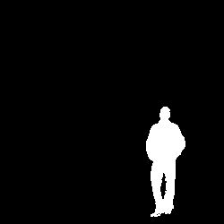

In [0]:
Image.fromarray(kornia.tensor_to_image((img['output'][0][0]*255).byte()))

In [0]:
#mmdmodels.UNet(n_channels=6, n_classes=2)

device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)

model_new = mmdtraintest.load_model_for_infer(model_new, 
                                  '/content/drive/My Drive/EVA4/baseline_models/S15Unet6_dice_ssim.h5',
                                  device)

In [0]:
img = iter(train_loader).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")

### Unet initial results with BCE and Dice


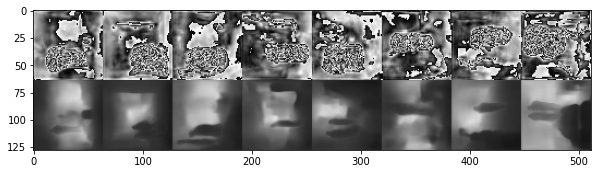

In [0]:
output_pred = torch.split(output_val,1,dim=1)
mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]

# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(8) ]

#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

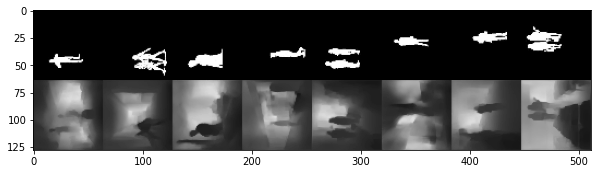

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

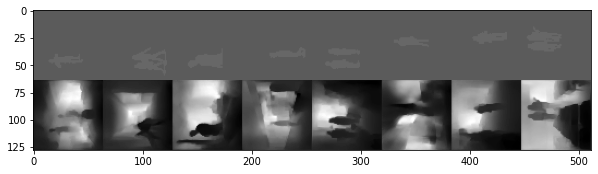

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

## Dice with RMSE

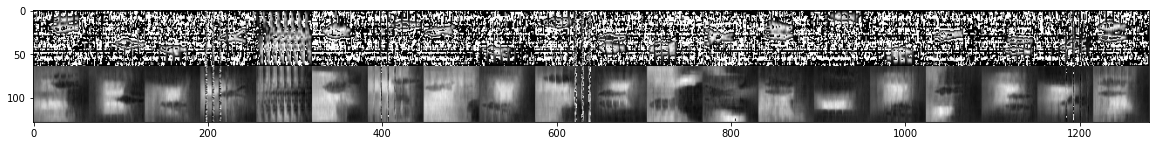

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(20,20)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

In [0]:
offset = 5
plt.imshow(np.hstack([img['output'][1][offset].reshape(64,64),
                      depth_pred[offset]]),cmap='gray')

                    #   img['output'][0][offset].reshape(64,64),
                    #   mask_pred[offset]]),
                    #  cmap='gray')

In [0]:
plt.imshow(img['output'][0][offset].reshape(64,64),cmap='gray')

### BCE with SSIM Epoch = 10, Train = 20,000 Test=512

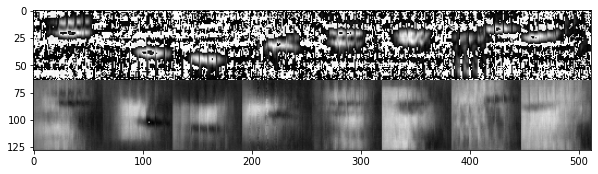

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

## Small batch RMSE

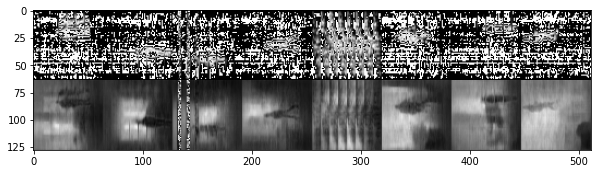

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

## BaseLine Predictions with plain RMSE (MonoMaskDepthResNet)

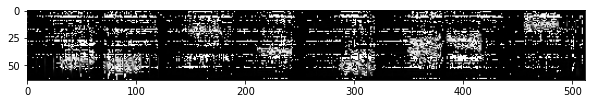

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(mask_pred),cmap='gray')

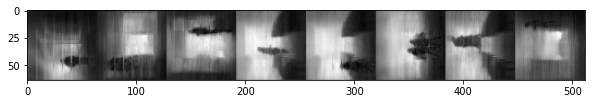

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(depth_pred),cmap='gray')